In [1]:
import pandas as pd

dataset = pd.read_csv('snow_obj.csv', delimiter='\t')
dataset.head()

,size,roughness,color,motion,label
0,50.959361,1.318226,green,0.054290,tree
1,60.008521,0.554291,brown,0.000000,tree
2,20.530772,1.097752,white,1.380464,tree
3,28.092138,0.966482,grey,0.650528,tree
4,48.344211,0.799093,grey,0.000000,tree


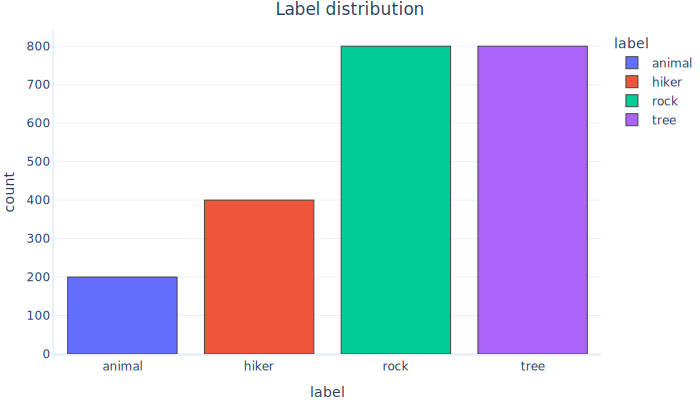

In [2]:
import graphing # custom graphing code. See our GitHub repo for details
import plotly.io as pio
pio.renderers.default = "svg" 

# Plot a histogram with counts for each label
graphing.multiple_histogram(dataset, label_x="label", label_group="label", title="Label distribution")

## Using binary classification

For this exercise we will build a *binary classification model*. We want to predict if objects in the snow are "hikers" or "not-hikers".

To do that, we first need to add another column to our dataset, and set it to `True` where the original label is `hiker`, and `False` to anything else:

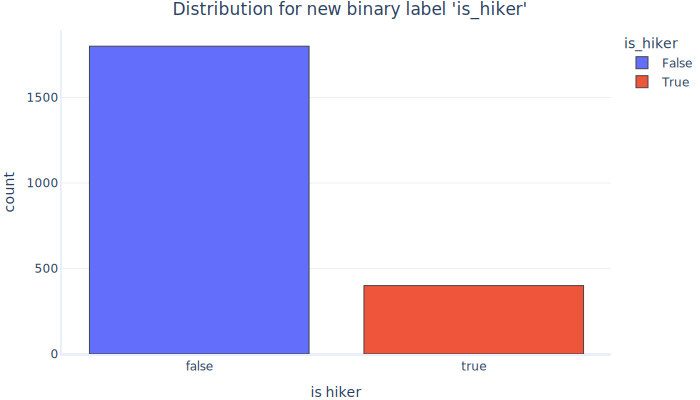

In [3]:
# Add a new label with true/false values to our dataset
dataset["is_hiker"] = dataset.label == "hiker"

# Plot frequency for new label
graphing.multiple_histogram(dataset, label_x="is_hiker", label_group="is_hiker", title="Distribution for new binary label 'is_hiker'")

In [4]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

def assess_accuracy(model, dataset, label):
    actual = dataset[label]
    predictions = model.predict(dataset[features])
    acc = accuracy_score(actual, predictions)
    return acc

train, test = train_test_split(dataset, test_size=0.2, random_state=2, shuffle=True)

model = RandomForestClassifier(n_estimators=1, random_state=1, verbose=False)

features = ['size', 'roughness', 'motion']

model.fit(train[features], train['is_hiker'])

print("Train accuracy:", assess_accuracy(model,train, "is_hiker"))
print("Test accuracy:", assess_accuracy(model,test, "is_hiker"))

Train accuracy: 0.9522727272727273
Test accuracy: 0.8772727272727273


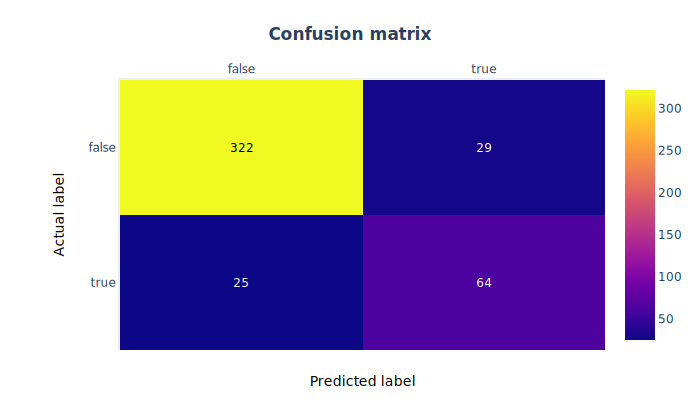

In [5]:
# sklearn has a very convenient utility to build confusion matrices
from sklearn.metrics import confusion_matrix
import plotly.figure_factory as ff

# Calculate the model's accuracy on the TEST set
actual = test.is_hiker
predictions = model.predict(test[features])

# Build and print our confusion matrix, using the actual values and predictions 
# from the test set, calculated in previous cells
cm = confusion_matrix(actual, predictions, normalize=None)

# Create the list of unique labels in the test set, to use in our plot
# I.e., ['True', 'False',]
unique_targets = sorted(list(test["is_hiker"].unique()))

# Convert values to lower case so the plot code can count the outcomes
x = y = [str(s).lower() for s in unique_targets]

# Plot the matrix above as a heatmap with annotations (values) in its cells
fig = ff.create_annotated_heatmap(cm, x, y)

# Set titles and ordering
fig.update_layout(  title_text="<b>Confusion matrix</b>", 
                    yaxis = dict(categoryorder = "category descending")
                    )

fig.add_annotation(dict(font=dict(color="black",size=14),
                        x=0.5,
                        y=-0.15,
                        showarrow=False,
                        text="Predicted label",
                        xref="paper",
                        yref="paper"))

fig.add_annotation(dict(font=dict(color="black",size=14),
                        x=-0.15,
                        y=0.5,
                        showarrow=False,
                        text="Actual label",
                        textangle=-90,
                        xref="paper",
                        yref="paper"))

# We need margins so the titles fit
fig.update_layout(margin=dict(t=80, r=20, l=120, b=50))
fig['data'][0]['showscale'] = True
fig.show()

The confusion matrix shows us that, despite the reported metrics, the model is not incredibly precise.

Out of the 660 samples present in the *test* set (30% of the total samples), it predicted `29` *false negatives* and `33` _false positives_.

More importantly, look at the bottom row, which shows what happened when the model was shown information about a hiker: it got the answer wrong almost 30% of the time. This means it would not correctly identify almost 30% of the people on the mountain!  

What happens if we used this model to make predictions on balanced sets?

Let's load a dataset with an equal number of outcomes for "hikers" and "non-hikers", then use that data to make predictions:

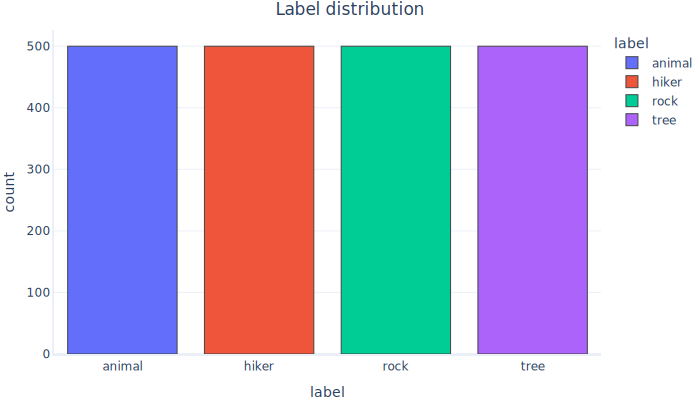

In [8]:
# Load and print umbiased set
#Import the data from the .csv file
balanced_dataset = pd.read_csv('snow_obj_balanced.csv', delimiter="\t")

#Let's have a look at the data
graphing.multiple_histogram(balanced_dataset, label_x="label", label_group="label", title="Label distribution")

          size  roughness   color    motion  label  is_hiker
1000  1.758147   0.578384   green  1.979197  hiker      True
1001  2.138218   1.096874  orange  2.103307  hiker      True
1002  1.729903   1.213756   brown  2.139579  hiker      True
1003  1.614283   0.889785   green  1.402956  hiker      True
1004  2.202475   0.933503   brown  2.337197  hiker      True


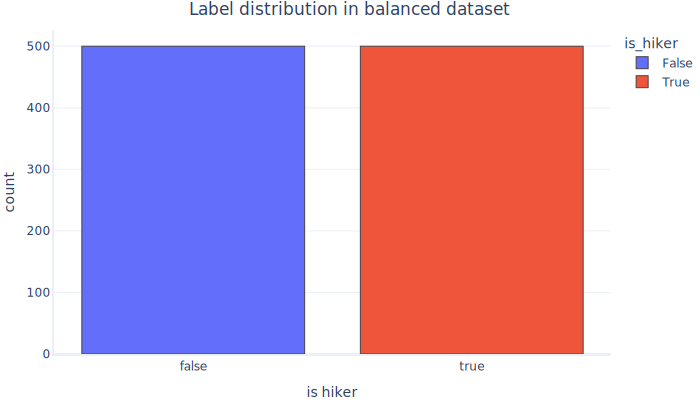

In [9]:
# Add a new label with true/false values to our dataset
balanced_dataset["is_hiker"] = balanced_dataset.label == "hiker"

hikers_dataset = balanced_dataset[balanced_dataset["is_hiker"] == 1] 
nonhikers_dataset = balanced_dataset[balanced_dataset["is_hiker"] == False] 
# take a random sampling of non-hikers the same size as the hikers subset
nonhikers_dataset = nonhikers_dataset.sample(n=len(hikers_dataset.index), random_state=1)
balanced_dataset = pd.concat([hikers_dataset, nonhikers_dataset])

print(balanced_dataset.head())

# Plot frequency for "is_hiker" labels
graphing.multiple_histogram(balanced_dataset, label_x="is_hiker", label_group="is_hiker", title="Label distribution in balanced dataset")

In [10]:
# Test the model using a balanced dataset
actual = balanced_dataset.is_hiker
predictions = model.predict(balanced_dataset[features])

# Build and print our confusion matrix, using the actual values and predictions 
# from the test set, calculated in previous cells
cm = confusion_matrix(actual, predictions, normalize=None)

# Print accuracy using this set
print("Balanced set accuracy:", assess_accuracy(model,balanced_dataset, "is_hiker"))

Balanced set accuracy: 0.742


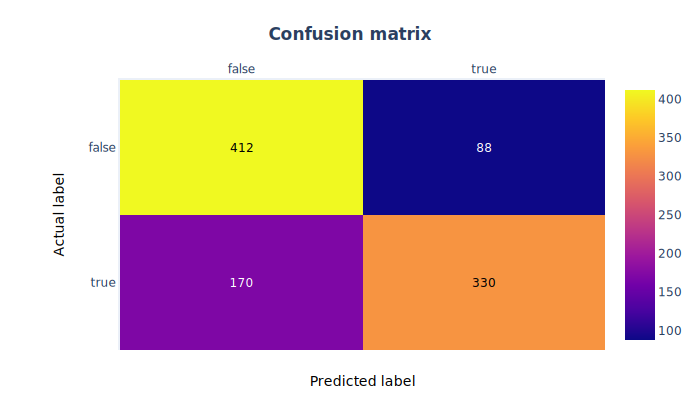

In [11]:
# plot new confusion matrix
# Create the list of unique labels in the test set to use in our plot
unique_targets = sorted(list(balanced_dataset["is_hiker"].unique()))

# Convert values to lower case so the plot code can count the outcomes
x = y = [str(s).lower() for s in unique_targets]

# Plot the matrix above as a heatmap with annotations (values) in its cells
fig = ff.create_annotated_heatmap(cm, x, y)

# Set titles and ordering
fig.update_layout(  title_text="<b>Confusion matrix</b>", 
                    yaxis = dict(categoryorder = "category descending")
                    )

fig.add_annotation(dict(font=dict(color="black",size=14),
                        x=0.5,
                        y=-0.15,
                        showarrow=False,
                        text="Predicted label",
                        xref="paper",
                        yref="paper"))

fig.add_annotation(dict(font=dict(color="black",size=14),
                        x=-0.15,
                        y=0.5,
                        showarrow=False,
                        text="Actual label",
                        textangle=-90,
                        xref="paper",
                        yref="paper"))

# We need margins so the titles fit
fig.update_layout(margin=dict(t=80, r=20, l=120, b=50))
fig['data'][0]['showscale'] = True
fig.show()

The confusion matrix confirms the poor accuracy using this dataset, but why is this happening when we had such excellent metrics in the earlier *train* and *test* sets?

Recall that the first model was heavily imbalanced. The "hiker" class made up roughly 22% of the outcomes.

When such an imbalance happens, classification models don't have enough data to learn the patterns for the minority __class__, and as a consequence become biased towards the __majority__ class!

Imbalanced sets can be addressed in a number of ways:

- Improving data selection
- Resampling the dataset
- Using weighted classes

For this exercise, we will focus on the last option.

## Using class weights to balance dataset

We can assign different *weights* to the majority and minority classes, according to their distribution, and modify our training algorithm so that it takes that information into account during the training phase.

It will then penalize errors when the minority class is misclassified, in essence "forcing" the model to to better learn their features and patterns.

To use weighted classes, we have to retrain our model using the original *train* set, but this time telling the algorithm to use weights when calculating errors:

In [12]:
# Import function used in calculating weights
from sklearn.utils import class_weight

# Retrain model using class weights
# Using class_weight="balanced" tells the algorithm to automatically calculate weights for us
weighted_model = RandomForestClassifier(n_estimators=1, random_state=1, verbose=False, class_weight="balanced")
# Train the weighted_model using binary label
weighted_model.fit(train[features], train.is_hiker)

print("Train accuracy:", assess_accuracy(weighted_model,train, "is_hiker"))
print("Test accuracy:", assess_accuracy(weighted_model, test, "is_hiker"))

Train accuracy: 0.9602272727272727
Test accuracy: 0.8704545454545455


In [13]:
print("Balanced set accuracy:", assess_accuracy(weighted_model, balanced_dataset, "is_hiker"))

# Test the weighted_model using a balanced dataset
actual = balanced_dataset.is_hiker
predictions = weighted_model.predict(balanced_dataset[features])

# Build and print our confusion matrix, using the actual values and predictions 
# from the test set, calculated in previous cells
cm = confusion_matrix(actual, predictions, normalize=None)

Balanced set accuracy: 0.758


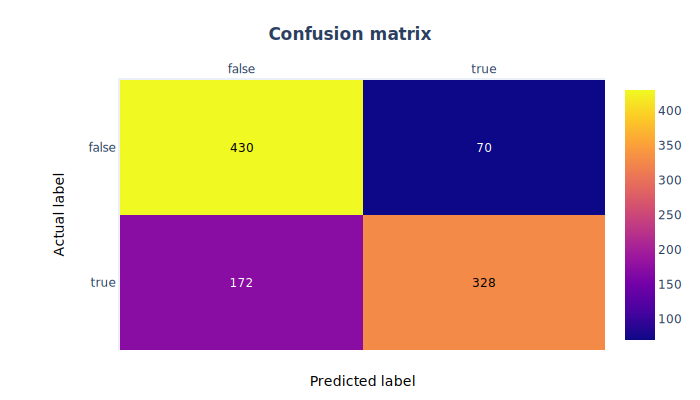

In [14]:
# Plot the matrix above as a heatmap with annotations (values) in its cells
fig = ff.create_annotated_heatmap(cm, x, y)

# Set titles and ordering
fig.update_layout(  title_text="<b>Confusion matrix</b>", 
                    yaxis = dict(categoryorder = "category descending")
                    )

fig.add_annotation(dict(font=dict(color="black",size=14),
                        x=0.5,
                        y=-0.15,
                        showarrow=False,
                        text="Predicted label",
                        xref="paper",
                        yref="paper"))

fig.add_annotation(dict(font=dict(color="black",size=14),
                        x=-0.15,
                        y=0.5,
                        showarrow=False,
                        text="Actual label",
                        textangle=-90,
                        xref="paper",
                        yref="paper"))

# We need margins so the titles fit
fig.update_layout(margin=dict(t=80, r=20, l=120, b=50))
fig['data'][0]['showscale'] = True
fig.show()